# BMEB W4020: Circuits in the Brain 2023Fall Homework \#3 Handout
*Author:* Shashwat Shukla <shashwat.shukla@columbia.edu> Bruce Yi Bu <yb2520@columbia.edu>


*Based on Previous Work by:* Tingkai Liu, Mehmet Kerem Turkcan, Chung-Heng Yeh,
                  Konstantinos Psychas, Cong Han

Copyright 2012-2023 Shashwat Shukla, Bruce Yi Bu, Tingkai Liu and Aurel A. Lazar


# PROBLEM \#1 - $\delta$-insensitive TDM

The stimulus of a single-input single-output (SISO) TEM is modeled as
a bandlimited function of the form
$$
u(t)= \sum_{k=1}^{15} u(kT) \frac{\sin \Omega (t-kT)}{\Omega (t-kT)},
$$
where $\Omega = 2 \pi \cdot 25$ Hz and $T=\frac{\pi}{\Omega}$.

Assume that the TEM describes a IAF neuron. After choosing appropriate TEM parameter values (provided in the skeleton) generate the trigger times in the time interval $[-2T, 18T]$.

### Tasks
1. Implement a threshold insensitive ($\delta$-insensitive) decoding algorithm for IAF.
2. Plot the recovery error (difference between the input stimulus and the recovered waveform) and calculate the whole-signal Signal-to-Noise ratio of the recovery in decibel (dB); plot SNR as function of time.
3. Compare the $\delta$-insensitive recovery result with the $\delta$-sensitive result (implementation of $\delta$-sensitive algorithm can be found in lecture notebook).


### Note
* The derivation of $\delta$-insensitive TDM decoding is available in **Chapter 6**. Highly recommend reading through the entire chapter thoroughly as it will **massively** help with the following chapters and lectures; pay attention to the *Compensation Principle*.

* Whole-signal SNR of the recovery can be calculated for signal $u(t)$ and recovered signal $u_{rec}(t)$ as 
$
SNR = 10\log_{10}\left(\frac{mean(u^2)}{mean((u-u_{rec})^2)}\right)
$
the result will be in dB
* To plot SNR as a function of time, use 
$
SNR = 10\log_{10}\left(\frac{u^2}{(u-u_{rec})^2}\right)
$ to preserve the time dimension.

# Problem 2 - Derivation of TEM/TDM algorithm for RHH Neuron with dendritic processing
In this problem you are asked to derive and implement a TEM/TDM algorithm for the reduced Hodgkin-Huxley neuron (BSG in the figure below) with dendritic processing modeled as a linear filter ($h(t)$ in the figure below).

The encoding circuit consisting of a filter in cascade with a RHH neuron:
   <center><img src="./filter-bsg.png" width=650/></center>

In the figure above, the external current injected into the neuron is given as 
$$
I_{ext}(t) = b + \underbrace{\left( u \ast h \right)(t)}_{v(t)}
$$
where $b$ is the injected current (also written as $I$ in other texts).


### Tasks
1. Generate the impulse response of $h(t)$ and visualize.
2. With $b=20$, encode a randomly generated input stimulus (from Problem 1) using a reduced PIF neuron that is equivalent to the HH neuron model. 
3. Derive an algorithm to recover the signal $u(t)$ from the recieved spikes.
    1. Writing down the $t$-transform of the encoding circuit shown above in an inner product form.
    2. Find the time decoding machine (TDM) that recovers the signal $u$. Particularly, provide forms for $q_k$ and $[G]_{lk}$. Please write down the important procedures.
3. Recover the signal $u(t)$ from output spike times of the reduced PIF and show encoding error and SNR (as in Problem \#1 above, calculate and plot).


### Stimulus and Filter
Use the stimulus $u(t)$ from Problem \#1, and the filter $h$ is 
$$
h(t)= 3 \cdot 150 \cdot \mbox{exp}\left(-100 t\right)\left(\frac{(150 t)^3}{3!}-\frac{(150t)^5}{5!}\right) \cdot \mathbb{1}_{t\ge 0},
$$
note that $\mathbb{1}_{t\ge 0}$ is also known as the Heaviside Step function which ensures that the filter $h(t)$ is causal.

### Note
You know the filter $h$ and filtered output $v(t) = (u \ast h)(t)$, but you _do not_ know $u(t)$. You can read the spike times, and you want to recover $u(t)$ from the spikes.

# Problem 1

In [67]:
%matplotlib inline
import numpy as np
np.random.seed(0)  # fix random seed
import matplotlib.pyplot as plt
import typing as tp

import typing as tp
from scipy import signal
from scipy.linalg import circulant
from scipy.integrate import cumulative_trapezoid as cumtrapz
from compneuro.utils.phase_response import PIF, iPRC
from compneuro.utils.neuron import limit_cycle
from compneuro.utils.signal import spike_detect, spike_detect_local
from compneuro.neurons.hodgkin_huxley_3state import HodgkinHuxley3State
from compneuro.utils.signal import convolve

plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams["figure.dpi"] = 100

In [5]:
# TODO: the stimulus ut
omega = 2 * np.pi * 25

def ut(t,T, omega):
    u_kt = np.random.rand(15)
    u = np.zeros_like(t)
    #for i in range(len(t)):
    for k in range(1, 16):
        u += u_kt[k-1] * np.sin(omega * (t-(k * T))) / (omega * (t-(k * T)))
    return u

In [6]:
def __init__(self, basis_func: tp.Callable):
    self.basis_func = basis_func

In [7]:
def sinc_basis(t, sk, omega):
    if np.isscalar(sk):
        return omega/np.pi * np.sinc(omega/np.pi*(t - sk))
    return omega/np.pi * np.sinc(omega/np.pi*(t[None,:] - sk[:,None]))

### Part 1. Implement a threshold insensitive ($\delta$-insensitive) decoding algorithm for IAF.

In [8]:
# TODO: implement IAF
iaf_params = dict(
    kappa = 1, # mF
    delta = 0.01,  #mV
    b = 1, #mu A
    omega = 2 * np.pi * 25,
)

def integrate_step_IAF(u, t, dt):
    V = np.zeros_like(u)
    tk_idx = []
    v = 0
    for i in np.arange(len(t)):
        v = v + dt / iaf_params['kappa'] * (u[i] + iaf_params['b'])
        if v >= iaf_params['delta']:
            tk_idx.append(i)
            v = v - iaf_params['delta']
        V[i] = v 
    return tk_idx, V

def iaf_encode(t, tk_idx):
     tk = t[tk_idx]
     return tk


In [9]:
# TODO: endode with IAF
dt = 1e-6
omega = 2 * np.pi * 25
T = np.pi/omega
t = np.arange(-2*T, 18*T, dt)
u = ut(t,T,omega)
tk_idx, V= integrate_step_IAF(u, t, dt)
tk = iaf_encode(t, tk_idx)

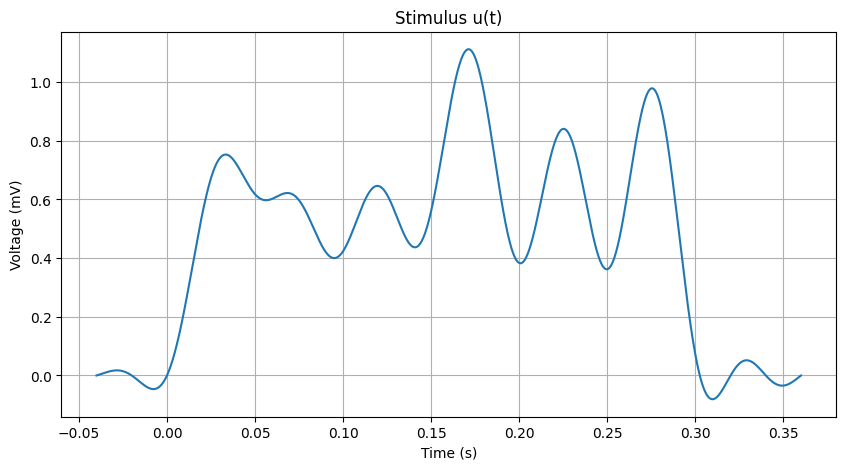

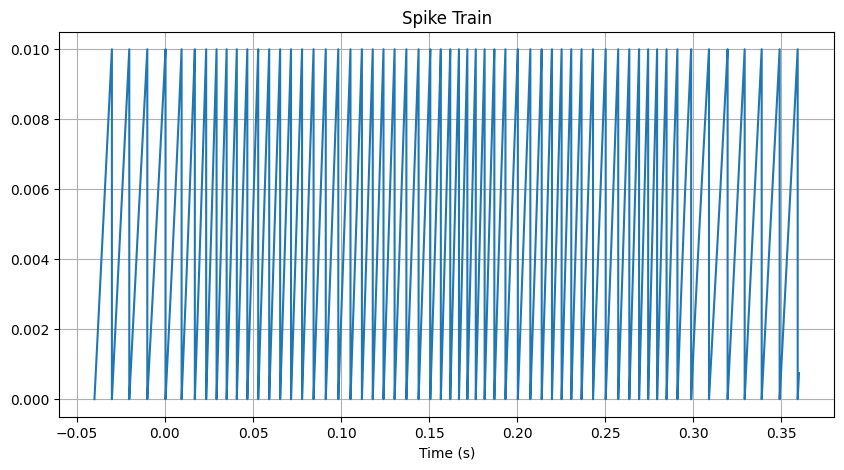

In [10]:
plt.figure(1)
plt.plot(t, u)
plt.xlabel("Time (s)")
plt.ylabel("Voltage (mV)")
plt.title("Stimulus u(t)")
plt.grid()

plt.figure(2)
plt.plot(t, V)
plt.xlabel("Time (s)")
plt.title("Spike Train")
plt.grid()

**Disclaimer** implementation of $\delta$-sensitive algorithm can be found in lecture notebook.

In [11]:
from scipy.integrate import cumulative_trapezoid as cumtrapz

In [12]:
# TODO: Recovery 
# functions for computing the matrices, you can (and probably should) add more
def compute_G(self, t, tk):
    dt = t[1] - t[0]
    s = 0.5 * (tk[:-1] + tk[1:])
    G = np.zeros((len(s), len(s))) 
    for i in range(len(s)):
        csum = cumtrapz(self.basis_func(t, s[i]), dx=dt, initial=0)
        G[:, i] = np.diff(csum[tk_idx])
    return G

def compute_q(self, t, tk, iaf_params):
    kappa = iaf_params['kappa']
    delta = iaf_params['delta']
    b =  iaf_params['b']
    q = kappa * delta - b * np.diff(tk)
    return q 


def iaf_decoder_sen(t, tk, iaf_params):
    # TODO: find the sensitive case
    class TimeDecodingMachine_sens:
        def __init__(self, basis_func: tp.Callable): 
            self.basis_func = basis_func

        def decode(self, t: np.ndarray, tk: np.ndarray, rcond: float=1e-15,q_kwargs: tp.Dict=None,G_kwargs: tp.Dict=None) -> tp.Union[np.ndarray, np.ndarray]:
            q_kwargs = {} if q_kwargs is None else q_kwargs
            G_kwargs = {} if G_kwargs is None else G_kwargs
            q = self.compute_q(t, tk, **q_kwargs)
            G = self.compute_G(t, tk, **G_kwargs)

            G_inv = np.linalg.pinv(G, rcond=rcond)
            c_rec = G_inv @ q
        
            sk = .5 * (tk[1:] + tk[:-1])
            u_rec = c_rec @ self.basis_func(t, sk)
            return c_rec, u_rec
    
    class IAFDeltaSensitive(TimeDecodingMachine_sens):
        def compute_G(self, t, tk, **kwargs):
            dt = t[1] - t[0]
            s = 0.5 * (tk[:-1] + tk[1:])
            G = np.zeros((len(s), len(s)))  # G matrix
            for i in range(len(s)):
                csum = cumtrapz(self.basis_func(t, s[i]), dx=dt, initial=0)
                G[:, i] = np.diff(csum[tk_idx])
            return G

        def compute_q(self, t, tk, **kwargs):
            C, delta, bias = kwargs['kappa'], kwargs['delta'], kwargs['b']
            return C * delta - bias * np.diff(tk)
    
    def basis_func(t, tk):
        return sinc_basis(t,tk,omega)

    iaf_sensitive_decoder = IAFDeltaSensitive(basis_func)

    c_sens, u_sens = iaf_sensitive_decoder.decode(t, tk, rcond=1e-7, q_kwargs=iaf_params)
    return c_sens, u_sens


def iaf_decoder_insen(t, tk, iaf_params):
    class TimeDecodingMachine_insens:
        def __init__(self, basis_func):
            self.basis_func = basis_func
        
        def decode(self, t: np.ndarray, tk: np.ndarray, rcond: float=1e-15,q_kwargs: tp.Dict=None,G_kwargs: tp.Dict=None) -> tp.Union[np.ndarray, np.ndarray]:
            q_kwargs = {} if q_kwargs is None else q_kwargs
            G_kwargs = {} if G_kwargs is None else G_kwargs
            q = self.compute_q(t, tk, **q_kwargs)
            G = self.compute_G(t, tk, **G_kwargs)

            sk = .5 * (tk[1:] + tk[:-1])
            B = np.diagflat(np.ones_like(sk) * -1) + np.diagflat(np.ones(len(sk)-1), 1)
            B_inv = np.linalg.inv(B)

            c_rec = B_inv @ np.linalg.pinv(B @ G @ B_inv, rcond = rcond) @ (B @ q)

            u_rec = c_rec @ self.basis_func(t, sk)
            return c_rec, u_rec
        
    class IAFDeltaInsensitive(TimeDecodingMachine_insens):
        def compute_G(self, t, tk, **kwargs):
            dt = t[1] - t[0]
            s = 0.5 * (tk[:-1] + tk[1:])
            G = np.zeros((len(s), len(s)))
            for i in range(len(s)):
                csum = cumtrapz(self.basis_func(t, s[i]), dx = dt, initial = 0)
                G[:, i] = np.diff(csum[tk_idx])
            return G
        
        def compute_q(self, t, tk, **kwargs):
            kappa, delta, bias = kwargs['kappa'], kwargs['delta'], kwargs['b']
            q = kappa * delta - bias * np.diff(tk)
            return q
        
    def basis_func(t, tk):
        return sinc_basis(t, tk, omega)
    
    iaf_insensitive_decoder = IAFDeltaInsensitive(basis_func)

    c_rec, u_rec = iaf_insensitive_decoder.decode(t, tk, rcond = 1e-7, q_kwargs = iaf_params)

    return c_rec, u_rec

#c_insens, u_rec_insens = iaf_decoder_insen(t, tk, iaf_params, 1e-15) # delta-insensitive recovery coefficients

In [15]:
c_insens, u_insens = iaf_decoder_insen(t, tk, iaf_params)

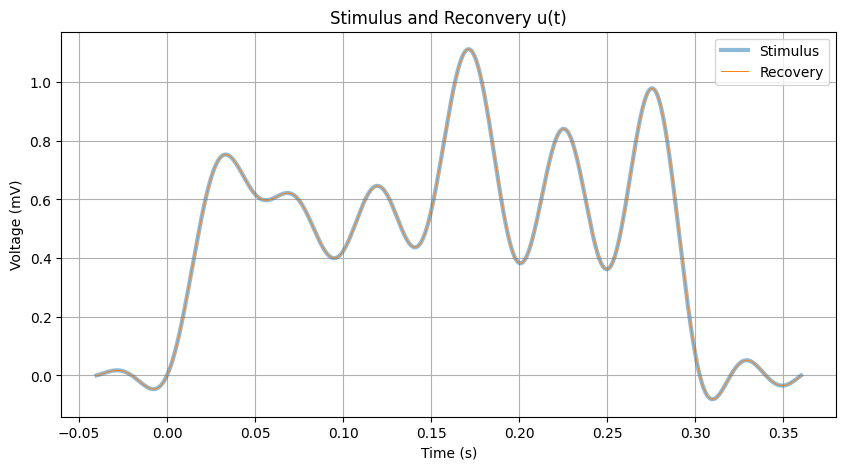

In [16]:
# TODO: Plot recovery (in the same plot with the original)
plt.figure(1)
plt.plot(t, u, label = "Stimulus", linewidth = 3, alpha = 0.5)
plt.plot(t, u_insens, label = "Recovery", linewidth = 0.7)
plt.xlabel("Time (s)")
plt.ylabel("Voltage (mV)")
plt.title("Stimulus and Reconvery u(t)")
plt.legend()
plt.grid()


### Part 2: Plot the recovery SNR

In [17]:
# Compute SNR 
# the SNR formula given in the question prompt is for whole-signal SNR
# which is a single value
# for SNR vs t plot use the function one below 
def SNR_f(u, u_rec):
    return 10 * np.log10(u**2 / (u-u_rec)**2)

<function matplotlib.pyplot.show(close=None, block=None)>

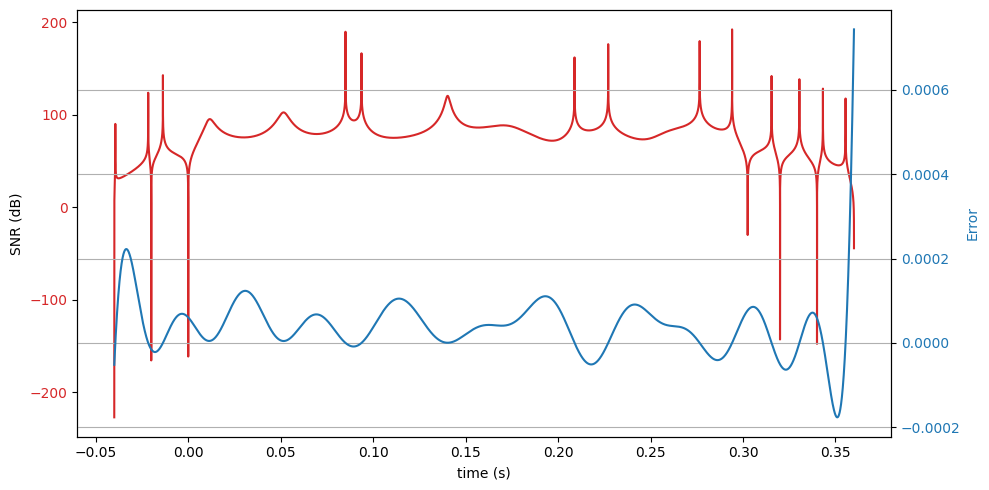

In [18]:
# TODO: plot the error and SNR as function of time
SNR = SNR_f(u, u_insens)

error = u - u_insens

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('SNR (dB)')
ax1.plot(t, SNR, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Error', color=color)
ax2.plot(t, error, color=color)
ax2.tick_params(axis='y', labelcolor = color)

fig.tight_layout()
plt.grid(axis='y')
plt.show

### Part 3: Compare the $\delta$-insensitive recovery result with the $\delta$-sensitive result 

In [19]:
def sinc_basis(t, sk, omega):
    if np.isscalar(sk):
        return omega/np.pi * np.sinc(omega/np.pi*(t - sk))
    return omega/np.pi * np.sinc(omega/np.pi*(t[None,:] - sk[:,None]))

In [109]:
# TODO: implement delta-sensitive case
class TimeDecodingMachine_sens:
    def __init__(self, basis_func: tp.Callable): 
        self.basis_func = basis_func

    def decode(self, t: np.ndarray, tk: np.ndarray, rcond: float=1e-15,q_kwargs: tp.Dict=None,G_kwargs: tp.Dict=None) -> tp.Union[np.ndarray, np.ndarray]:
        q_kwargs = {} if q_kwargs is None else q_kwargs
        G_kwargs = {} if G_kwargs is None else G_kwargs
        q = self.compute_q(t, tk, **q_kwargs)
        G = self.compute_G(t, tk, **G_kwargs)

        G_inv = np.linalg.pinv(G, rcond=rcond)
        c_rec = G_inv @ q
        
        sk = .5 * (tk[1:] + tk[:-1])
        u_rec = c_rec @ self.basis_func(t, sk)
        return c_rec, u_rec
    
class IAFDeltaSensitive(TimeDecodingMachine_sens):
    def compute_G(self, t, tk, **kwargs):
        dt = t[1] - t[0]
        s = 0.5 * (tk[:-1] + tk[1:])
        G = np.zeros((len(s), len(s)))  # G matrix
        for i in range(len(s)):
            csum = cumtrapz(self.basis_func(t, s[i]), dx=dt, initial=0)
            G[:, i] = np.diff(csum[tk_idx])
        return G

    def compute_q(self, t, tk, **kwargs):
        C, delta, bias = kwargs['kappa'], kwargs['delta'], kwargs['b']
        return C * delta - bias * np.diff(tk)
    
def basis_func(t, tk):
    return sinc_basis(t,tk,omega)

iaf_sensitive_decoder = IAFDeltaSensitive(basis_func)

c_sens, u_sens = iaf_sensitive_decoder.decode(t, tk, rcond=1e-7, q_kwargs=iaf_params)


In [20]:
c_sens, u_sens = iaf_decoder_sen(t, tk, iaf_params)

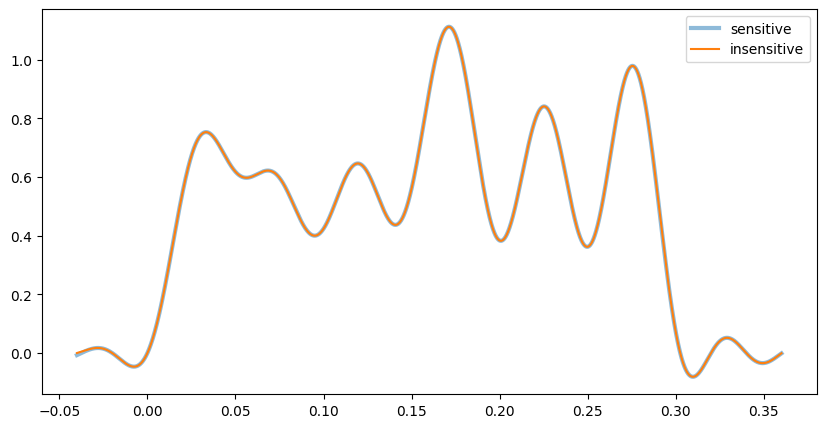

<Figure size 1000x500 with 0 Axes>

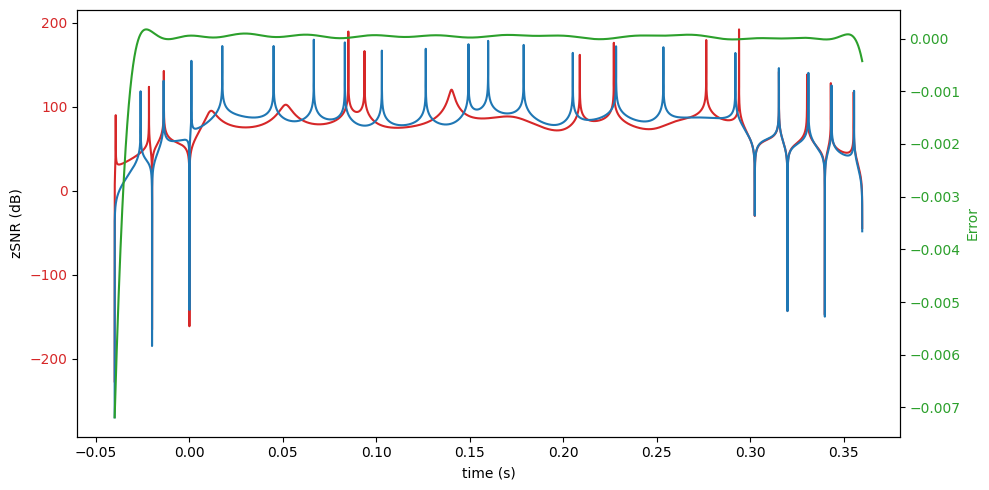

In [22]:
# TODO: Compare between sensitive and insensitive, 
# plot both outputs in same plot with original 
# (make use of legends and labels, feel free to adjust linewidth)

# plot both SNR in the same plot

plt.figure(1)
plt.plot(t, u_sens, label = 'sensitive', linewidth = 3, alpha = 0.5)
plt.plot(t, u_insens, label = 'insensitive')
plt.legend()

error = u_sens - u_insens

SNR_sens = SNR_f(u, u_sens)

plt.figure(2)
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('zSNR (dB)')
ax1.plot(t, SNR, color=color)
ax1.plot(t, SNR_sens)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:green'
ax2.set_ylabel('Error', color=color)
ax2.plot(t, error, color=color)
ax2.tick_params(axis='y', labelcolor = color)

fig.tight_layout()


# Problem 2

### Part 1. Generate and show the inpulse response of the filter
***HINT:*** *For this problem, pay attention to singal time vector, filter time vector and their convolution output lengths.*

In [23]:
b = 20

In [58]:
T_1 = 0
T_2 = 0.1
dt = 1e-5
t_filt = np.arange(T_1, T_2, dt)
a = 150
h = (
    3
    * a
    * np.exp(-100 * t_filt)
    * (
        (a * t_filt) ** 3 / np.math.factorial(3)
        - (a * t_filt) ** 5 / np.math.factorial(5)
    )
)  # dendritic filter

In [59]:
len(t_filt)

10000

In [60]:
I = b + np.convolve(u, h)

In [61]:
len(I)

409999

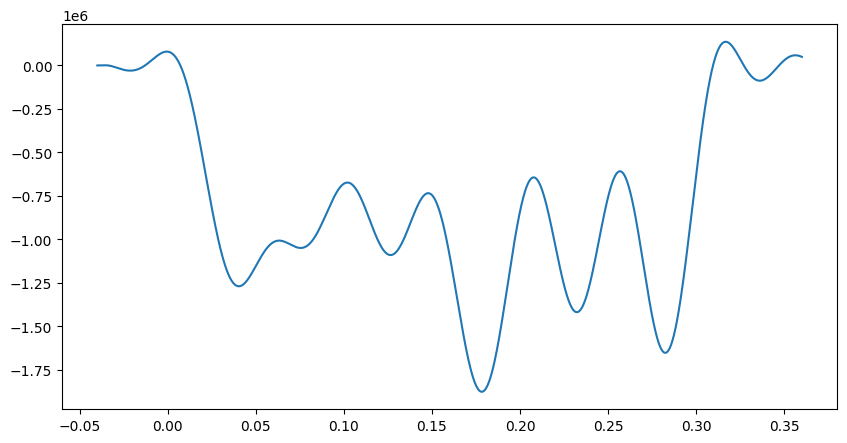

In [62]:
# TODO: plot the inpulse response
plt.plot(t, I[:400000])

### Part 2. Encode a randomly generated input stimulus (from Problem 1) using a reduced PIF neuron that is equivalent to the RHH neuron model. 

In [ ]:
# TODO: filter signal
v = PIF(t, u, PRC[0])

In [65]:
import inspect
from IPython.display import Code

In [66]:
Code(inspect.getsource(PRC), language='python')

NameError: name 'PRC' is not defined

In [68]:
# TODO: compute iPRC at given bias
rhh = HodgkinHuxley3State()
_, _, psi = iPRC(rhh, dt, I_ext=b, verbose=True, spike_threshold=-10)
# Plot the iPRC

  0%|          | 0/100000 [00:00<?, ?it/s]

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 3 is different from 1)

In [ ]:
# TODO: Compute PIF from iPRC
pif_spike_time =  np.nan

### Part 3. Recover the signal $u(t)$ from the recieved spikes.

**TODO: A.** Write down the t-transform of the encoding circuit in an inner product form

**TODO: B.** Write down $q_k$ and $[G]_{lk}$, as well the important procedures/steps to obtain $u(t)$ given $h$ (in equation form would suffice)

### Part 4. Recover the signal $u(t)$ from PIF spike times and show the statistics

In [ ]:
# TODO:implement PIF decoder

# def compute_G():
# def compute_q():

In [ ]:
# TODO: recover u(t)
c_rec, u_rec = np.nan

In [ ]:
# TODO: plot recovery result (in same plot as original), and SNR (as fn of time)
# The recovery may be bad at the boundary because all signals are finite, 
# you can focus on the middle part of the signal for comparison.

### Miscellaneous (attention)
* please remember to include your name in the corresponding field at the start of this notebook, otherwize an automatic 0 grade will be received for any missing member
* please submit one copy per team
* please clearly present your solutions and answers with proper use of plots, markdown and comments
* please start the assignment as soon as possible, submission deadlines are strictly followed and late submissions after we posted the solution (ususlly on the same day as the deadline) will receive automatic 0
* please email both TAs at least 48hrs ahead of deadline if you cannot submit an assignment on time (due to exam schedules or  overwhelming deadlines, etc), we are flexible as long as we are informed
* please post your questions on Ed Discussions, and attend the office hours (every Thursday evening); **more on Ed**:
    * while discussing on Ed, please make good use of the reply and comment features inside threads to avoid cluttering with multiple threads regarding the same question from the same user
    * please refrain from asking questions or posting threads that would explicitly share the right answer with everyone
    * only post code snipets when you have narrowed down the issue to that particular section and only share ploted results only when you have good reason to suspect their correctness
    * once you finish debugging your code by the end of a thread, please avoid languages such as "is this correct now?" since we aren't really allowed to explicitly say yes when they are; be confident in your hardwork.